### 분석준비

In [1]:
# 필요 라이브러리

# 분석을 위한 라이브러리
import numpy as np
import pandas as pd

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import os

# 에러메세지 안나오게
import warnings
warnings.filterwarnings('ignore')

# pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows',None)

#워드클라우드
from wordcloud import WordCloud 
from PIL import *

In [2]:
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] =False

In [3]:
# 디비 연결
def rds_python_conn():
    import psycopg2
    import json
    from sqlalchemy import create_engine
    # rds와 python 연동을 위한 정보 입력
    with open('postgres.info.json','r') as json_file:
        db_info = json.load(json_file)

    host = db_info.get('host')
    dbname = 'postgres' 
    user = 'postgres' 
    password = db_info.get('password')
    port = 5432

    connection = psycopg2.connect(host=host,
                                  dbname=dbname ,
                                  user=user ,
                                  password=password ,
                                  port=port)
    return connection

def sql(SQL):
    connection = rds_python_conn()
    cur = connection.cursor()

    cur.execute(SQL)
    rows = cur.fetchall()
    return rows


### 비즈니스타입과 회사타입에 따른 매출과 개수파악

In [4]:
SQL = """
SELECT customer_id, customer_unique_id, customer_state
FROM customers;
"""

customers = pd.read_sql(SQL, rds_python_conn())
customers

,customer_id,customer_unique_id,customer_state
0,93596,86343,SP
1,96387,55527,SP
2,71593,44820,SP
3,17589,36016,SP
4,46972,96049,SP
...,...,...,...
99436,40421,29126,SP
99437,65930,3710,SP
99438,83443,38830,CE
99439,52687,79036,RS


In [5]:
SQL = """
SELECT order_id,customer_id,order_status, order_purchase_timestamp
FROM "order"
where order_status in  ('delivered','shipped','invoiced','processing');
"""

orders = pd.read_sql(SQL, rds_python_conn())
orders

,order_id,customer_id,order_status,order_purchase_timestamp
0,13974,65773,delivered,2017-10-02 10:56:33
1,83165,13301,delivered,2018-07-24 20:41:37
2,66104,44559,delivered,2018-08-08 08:38:49
3,64037,69256,delivered,2017-11-18 19:28:06
4,14183,35294,delivered,2018-02-13 21:18:39
...,...,...,...,...
98195,63791,92532,delivered,2017-03-09 09:54:05
98196,85704,30689,delivered,2018-02-06 12:58:58
98197,19817,23177,delivered,2017-08-27 14:46:43
98198,6896,84231,delivered,2018-01-08 21:28:27


In [6]:
order_customer = orders.merge(customers,on='customer_id')
order_customer['order_time'] = order_customer['order_purchase_timestamp'].dt.strftime('%Y-%m')
order_customer

,order_id,customer_id,order_status,order_purchase_timestamp,customer_unique_id,customer_state,order_time
0,13974,65773,delivered,2017-10-02 10:56:33,39184,SP,2017-10
1,83165,13301,delivered,2018-07-24 20:41:37,71798,BA,2018-07
2,66104,44559,delivered,2018-08-08 08:38:49,24317,GO,2018-08
3,64037,69256,delivered,2017-11-18 19:28:06,45377,RN,2017-11
4,14183,35294,delivered,2018-02-13 21:18:39,74487,SP,2018-02
...,...,...,...,...,...,...,...
98195,63791,92532,delivered,2017-03-09 09:54:05,73555,SP,2017-03
98196,85704,30689,delivered,2018-02-06 12:58:58,5260,SP,2018-02
98197,19817,23177,delivered,2017-08-27 14:46:43,63257,BA,2017-08
98198,6896,84231,delivered,2018-01-08 21:28:27,82042,RJ,2018-01


In [ ]:
---------------------------------------------------

In [61]:
SQL = """
SELECT order_id, review_score, review_comment_message
FROM reviews
"""

reviews = pd.read_sql(SQL, rds_python_conn())
reviews

,order_id,review_score,review_comment_message
0,64002,4,None
1,78339,5,None
2,25907,5,None
3,80635,5,Recebi bem antes do prazo estipulado.
4,72488,5,Parabéns lojas lannister adorei comprar pela I...
...,...,...,...
99219,96979,5,None
99220,9999,5,None
99221,67181,5,"Excelente mochila, entrega super rápida. Super..."
99222,81384,4,None


In [60]:
SQL = """
SELECT order_id,customer_id,order_purchase_timestamp
FROM "order"
where order_status in  ('delivered','shipped','invoiced','processing');
"""

order = pd.read_sql(SQL, rds_python_conn())
order

,order_id,customer_id,order_purchase_timestamp
0,13974,65773,2017-10-02 10:56:33
1,83165,13301,2018-07-24 20:41:37
2,66104,44559,2018-08-08 08:38:49
3,64037,69256,2017-11-18 19:28:06
4,14183,35294,2018-02-13 21:18:39
...,...,...,...
98195,63791,92532,2017-03-09 09:54:05
98196,85704,30689,2018-02-06 12:58:58
98197,19817,23177,2017-08-27 14:46:43
98198,6896,84231,2018-01-08 21:28:27


In [6]:
revi = order.merge(reviews,on='order_id',how='left')
revi

,order_id,order_status,review_score,review_comment_message
0,13974,delivered,4.0,"Não testei o produto ainda, mas ele veio corre..."
1,83165,delivered,4.0,Muito bom o produto.
2,66104,delivered,5.0,None
3,64037,delivered,5.0,O produto foi exatamente o que eu esperava e e...
4,14183,delivered,5.0,None
...,...,...,...,...
98740,63791,delivered,5.0,None
98741,85704,delivered,4.0,So uma peça que veio rachado mas tudo bem rs
98742,19817,delivered,5.0,Foi entregue antes do prazo.
98743,6896,delivered,2.0,Foi entregue somente 1. Quero saber do outro p...


In [7]:
revi[revi['review_comment_message'].isnull()]['review_score'].value_counts(normalize=True)

review_score
5.0    0.634594
4.0    0.226983
3.0    0.079158
1.0    0.042258
2.0    0.017007
Name: proportion, dtype: float64

In [8]:
(revi.review_score.value_counts(normalize=True)*100)

review_score
5.0    58.382051
4.0    19.482110
1.0    10.749594
3.0     8.260129
2.0     3.126116
Name: proportion, dtype: float64

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '5.0'),
  Text(1, 0, '4.0'),
  Text(2, 0, '1.0'),
  Text(3, 0, '3.0'),
  Text(4, 0, '2.0')])

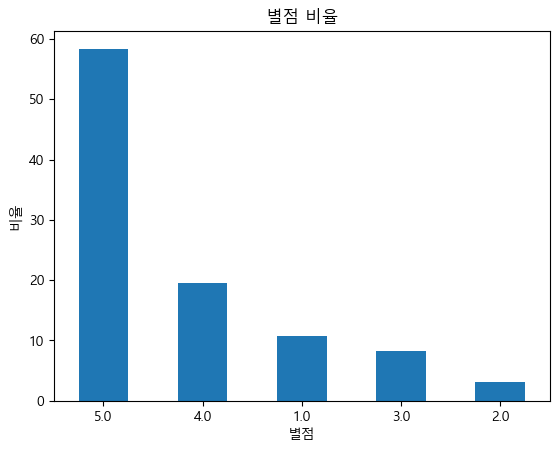

In [9]:
(revi.review_score.value_counts(normalize=True)*100).plot.bar()
plt.title('별점 비율')
plt.ylabel('비율')
plt.xlabel('별점')
plt.xticks(rotation=0)

In [16]:
revi_ =revi[(revi['review_comment_message'].notnull())&(revi['review_score']<=2)] # 여기서 123점과 45점을 나눔.
revi_

,order_id,order_status,review_score,review_comment_message
6,5625,invoiced,2.0,fiquei triste por n ter me atendido.
10,89094,delivered,1.0,Aguardando retorno da loja
20,69654,delivered,2.0,os correios estäo em greve... näo recebi nenhu...
25,61811,delivered,2.0,Demora muito entregar. Já passou o prazo e ain...
26,35035,delivered,1.0,Até o momento não recebi o produto Protetor De...
...,...,...,...,...
98707,69628,delivered,1.0,Não gostei imaginei que era uma cortina de tec...
98727,35099,delivered,1.0,nao recebi o produto que ja paguei ! nao recom...
98729,71978,delivered,1.0,"Prateleiras com cantos vivo, colunas nao encai..."
98736,73258,delivered,1.0,"Ele não é um mini cajon, é um shaker, ou seja,..."


In [34]:
def split_text(text):
    return text.lower().split()  # 공백을 기준으로 쪼개어 리스트로 변환

revi_['new_message'] = revi_['review_comment_message'].apply(split_text)

In [39]:
from nltk.tokenize.regexp import RegexpTokenizer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# 불용어 다운로드
nltk.download('stopwords')
nltk.download('punkt')

# 브라질 포르투갈어의 불용어 가져오기
stop_words = set(stopwords.words('portuguese'))

# 불용어 제거와 토큰화 수행
filtered_texts = []
for text_list in revi_['new_message']:
    filtered_text = [re.sub(r"[^\w\s]|produto", '', word) for word in text_list if word.lower() not in stop_words]
    filtered_text = [re.sub(r'\d', '', word) for word in filtered_text]  # 숫자 제거 및 빈 문자열 필터링
    filtered_texts.append(filtered_text)


# 결과 출력
all_ = []
for i in filtered_texts:
    for j in i:
        all_.append(j.strip())

[nltk_data] Downloading package stopwords to C:\Users\KIMJEONGSU.DESKT
[nltk_data]     OP-3GN3AD1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\KIMJEONGSU.DESKTOP-3
[nltk_data]     GN3AD1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
from collections import Counter

# 각 텍스트 리스트에서 단어 빈도수 계산
word_frequencies = Counter(all_)

word_frequencies = word_frequencies.most_common(50)

# 단어와 빈도수로 구성된 리스트를 데이터프레임으로 변환
df_word_frequencies = pd.DataFrame(word_frequencies, columns=['Word', 'Frequency'])

print(df_word_frequencies)

          Word  Frequency
0                   10101
1       recebi       3070
2      comprei       1779
3         veio       1506
4        ainda       1312
5      entrega       1279
6     entregue       1242
7       chegou       1125
8          nao        860
9        prazo        830
10      compra        771
11      pedido        705
12         dia        698
13        loja        676
14       agora        615
15      apenas        533
16           s        503
17        dois        483
18        nada        477
19        pois        465
20        site        465
21       quero        450
22   lannister        428
23     contato        426
24   qualidade        417
25       outro        412
26         pra        388
27  aguardando        386
28        dias        385
29       porém        374
30         fiz        360
31     momento        357
32    correios        343
33        nota        331
34        duas        326
35   recomendo        326
36      paguei        318
37    respos

In [41]:
dic_ = dict(word_frequencies)
dic_

{'': 10101,
 'recebi': 3070,
 'comprei': 1779,
 'veio': 1506,
 'ainda': 1312,
 'entrega': 1279,
 'entregue': 1242,
 'chegou': 1125,
 'nao': 860,
 'prazo': 830,
 'compra': 771,
 'pedido': 705,
 'dia': 698,
 'loja': 676,
 'agora': 615,
 'apenas': 533,
 's': 503,
 'dois': 483,
 'nada': 477,
 'pois': 465,
 'site': 465,
 'quero': 450,
 'lannister': 428,
 'contato': 426,
 'qualidade': 417,
 'outro': 412,
 'pra': 388,
 'aguardando': 386,
 'dias': 385,
 'porém': 374,
 'fiz': 360,
 'momento': 357,
 'correios': 343,
 'nota': 331,
 'duas': 326,
 'recomendo': 326,
 'paguei': 318,
 'resposta': 316,
 'receber': 305,
 'diferente': 305,
 'pedi': 289,
 'aguardo': 288,
 'problema': 286,
 'q': 285,
 'retorno': 282,
 'dinheiro': 268,
 'troca': 264,
 'vou': 263,
 'entregaram': 261,
 'errado': 261}

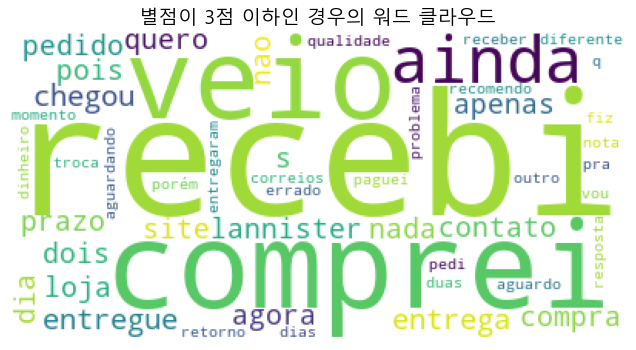

In [42]:
wordcloud = WordCloud(relative_scaling = 0.2,
                      background_color='white',
                      ).generate_from_frequencies(dic_)
plt.figure(figsize=(10,4))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('별점이 1,2점인 경우의 워드 클라우드',fontsize=14)
plt.show( )

### 리뷰와매출

In [64]:
SQL = """
SELECT order_id, payment_value
FROM payments

"""

payments = pd.read_sql(SQL, rds_python_conn())
payments

,order_id,payment_value
0,93586,99.33
1,2955,24.39
2,82474,65.71
3,55775,107.78
4,4054,128.45
...,...,...
103881,56307,363.31
103882,35667,96.80
103883,61044,47.77
103884,38153,369.54


In [72]:
SQL = """
SELECT order_id, review_score, review_comment_message
FROM reviews
"""

reviews = pd.read_sql(SQL, rds_python_conn())
reviews

,order_id,review_score,review_comment_message
0,64002,4,None
1,78339,5,None
2,25907,5,None
3,80635,5,Recebi bem antes do prazo estipulado.
4,72488,5,Parabéns lojas lannister adorei comprar pela I...
...,...,...,...
99219,96979,5,None
99220,9999,5,None
99221,67181,5,"Excelente mochila, entrega super rápida. Super..."
99222,81384,4,None


In [73]:
SQL = """
SELECT order_id,customer_id,order_purchase_timestamp
FROM "order"
where order_status in  ('delivered','shipped','invoiced','processing');
"""

order = pd.read_sql(SQL, rds_python_conn())
order

,order_id,customer_id,order_purchase_timestamp
0,13974,65773,2017-10-02 10:56:33
1,83165,13301,2018-07-24 20:41:37
2,66104,44559,2018-08-08 08:38:49
3,64037,69256,2017-11-18 19:28:06
4,14183,35294,2018-02-13 21:18:39
...,...,...,...
98195,63791,92532,2017-03-09 09:54:05
98196,85704,30689,2018-02-06 12:58:58
98197,19817,23177,2017-08-27 14:46:43
98198,6896,84231,2018-01-08 21:28:27


In [78]:
# 매출과 리뷰건수 비교
df = order.merge(reviews,on='order_id',how='left')
df2 = df.merge(payments,on='order_id',how='left')
df2['date'] = df2['order_purchase_timestamp'].dt.strftime('%Y-%m')
df2

,order_id,customer_id,order_purchase_timestamp,review_score,review_comment_message,payment_value,date
0,13974,65773,2017-10-02 10:56:33,4.0,"Não testei o produto ainda, mas ele veio corre...",18.12,2017-10
1,13974,65773,2017-10-02 10:56:33,4.0,"Não testei o produto ainda, mas ele veio corre...",2.00,2017-10
2,13974,65773,2017-10-02 10:56:33,4.0,"Não testei o produto ainda, mas ele veio corre...",18.59,2017-10
3,83165,13301,2018-07-24 20:41:37,4.0,Muito bom o produto.,141.46,2018-07
4,66104,44559,2018-08-08 08:38:49,5.0,None,179.12,2018-08
...,...,...,...,...,...,...,...
103147,63791,92532,2017-03-09 09:54:05,5.0,None,85.08,2017-03
103148,85704,30689,2018-02-06 12:58:58,4.0,So uma peça que veio rachado mas tudo bem rs,195.00,2018-02
103149,19817,23177,2017-08-27 14:46:43,5.0,Foi entregue antes do prazo.,271.01,2017-08
103150,6896,84231,2018-01-08 21:28:27,2.0,Foi entregue somente 1. Quero saber do outro p...,441.16,2018-01


date
2016-09       2
2016-10      65
2017-01     115
2017-02     235
2017-03     332
2017-04     350
2017-05     425
2017-06     382
2017-07     431
2017-08     453
2017-09     486
2017-10     536
2017-11    1305
2017-12     877
2018-01    1058
2018-02    1317
2018-03    1599
2018-04     878
2018-05     780
2018-06     643
2018-07     643
2018-08     647
Name: order_id, dtype: int64


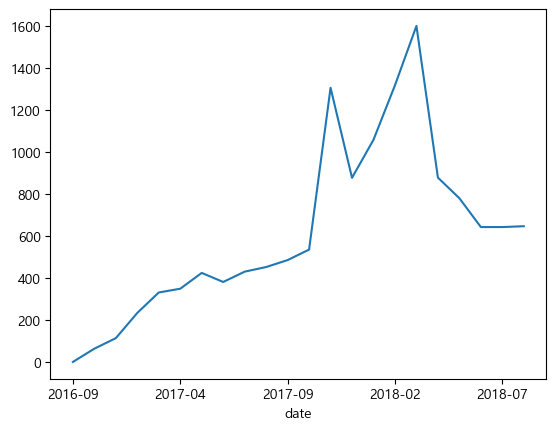

In [86]:
df3 = df2[(df2.review_score<3)&(df2.date!='2018-09')].drop_duplicates(subset=['order_id','order_purchase_timestamp'])
df3.groupby('date')['order_id'].count().plot()
print(df3.groupby('date')['order_id'].count())

In [110]:
text_2018 = df2[df2.date>'2018-04']['review_comment_message'].count()
text_2017 = df2[(df2.date>'2017-04')&(df2.date<'2017-09')]['review_comment_message'].count()
text_2018,text_2017

(10282, 6610)

In [128]:
df5 = df2[(df2.review_score<3)&(df2.date!='2018-09')].drop_duplicates(subset=['order_id','order_purchase_timestamp','review_comment_message'])
df5

,order_id,customer_id,order_purchase_timestamp,review_score,review_comment_message,payment_value,date
8,5625,16101,2017-04-11 12:22:08,2.0,fiquei triste por n ter me atendido.,65.95,2017-04
10,57028,67307,2017-01-23 18:29:09,1.0,None,35.95,2017-01
13,89094,32782,2017-05-16 19:41:10,1.0,Aguardando retorno da loja,259.06,2017-05
25,69654,48736,2017-09-18 14:31:30,2.0,os correios estäo em greve... näo recebi nenhu...,118.86,2017-09
30,61811,52133,2018-02-20 23:46:53,2.0,Demora muito entregar. Já passou o prazo e ain...,125.43,2018-02
...,...,...,...,...,...,...,...
103112,69628,56757,2018-02-04 14:35:02,1.0,Não gostei imaginei que era uma cortina de tec...,50.85,2018-02
103132,35099,21893,2017-10-12 20:54:11,1.0,nao recebi o produto que ja paguei ! nao recom...,48.75,2017-10
103134,71978,54727,2018-03-21 19:47:18,1.0,"Prateleiras com cantos vivo, colunas nao encai...",146.83,2018-03
103141,73258,82399,2017-12-20 09:52:41,1.0,"Ele não é um mini cajon, é um shaker, ou seja,...",71.04,2017-12


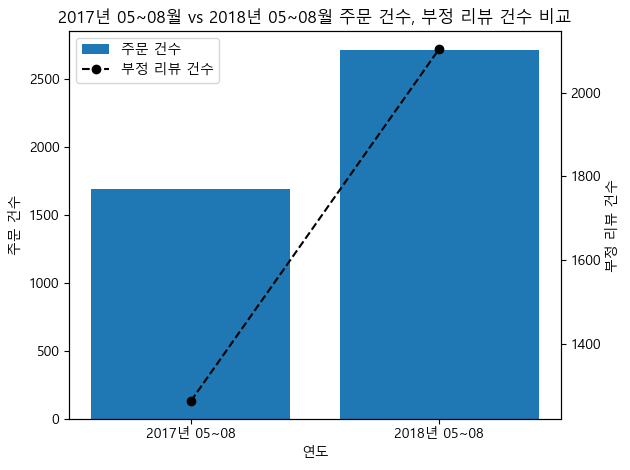

In [129]:
import matplotlib.pyplot as plt

# 주문 건수 데이터
num_2018 = df4[df4['date'] > '2018-04']['order_id'].sum()
num_2017 = df4[(df4['date'] > '2017-04') & (df4['date'] < '2017-09')]['order_id'].sum()

# 부정 리뷰 건수 데이터
text_2018 = df5[df5['date'] > '2018-04']['review_comment_message'].count()
text_2017 = df5[(df5['date'] > '2017-04') & (df5['date'] < '2017-09')]['review_comment_message'].count()

# 그래프 생성
fig, ax1 = plt.subplots()

# 주문 건수 막대 그래프
ax1.bar(x=['2017년 05~08월', '2018년 05~08월'], height=[num_2017, num_2018], label='주문 건수')
ax1.set_xlabel('연도')
ax1.set_ylabel('주문 건수')
ax1.tick_params(axis='y')

# 부정 리뷰 건수 선 그래프 (새로운 Y축 추가)
ax2 = ax1.twinx()
ax2.plot(['2017년 05~08', '2018년 05~08'], [text_2017, text_2018], marker='o', color='black', linestyle='--', label='부정 리뷰 건수')
ax2.set_ylabel('부정 리뷰 건수')
ax2.tick_params(axis='y')

# 제목과 범례 추가
plt.title('2017년 05~08월 vs 2018년 05~08월 주문 건수, 부정 리뷰 건수 비교')
fig.tight_layout()
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

In [132]:
print(num_2017,num_2018,text_2017,text_2018)
print((num_2018-num_2017)/num_2017,(text_2018-text_2017)/text_2017)

1691 2713 1264 2104
0.6043761088113542 0.6645569620253164
